# II. Symbolic decomposition of neural representation

## Thomas attractor rotation

In [1]:
import symengine as sm
import sympy as smp
import numpy as np
from functools import cmp_to_key

from utils import mv_series, compare_degrees, get_poly_dict, get_target_coeffs, get_term_name

In [2]:
def g(x):
    return sm.tanh(x)

def g_np(x):
    return np.tanh(x)

def dg(x):
    return 1 - sm.tanh(x) * sm.tanh(x)

def dg_np(x):
    return 1 - np.tanh(x) * np.tanh(x)

def ddg(x):
    return 2 * (sm.tanh(x) * sm.tanh(x) - 1) * sm.tanh(x)

In [3]:
x_dim = 3
r_dim = 100

In [4]:
# Symbols

x_list = [sm.Symbol(f'x_{i}') for i in range(x_dim)]
x_dot_list = [sm.Symbol('\dot{x}_' + f'{i}') for i in range(x_dim)]

x = sm.Matrix([[x_i] for x_i in x_list])
x_dot = sm.Matrix([[x_dot_i] for x_dot_i in x_dot_list])

In [5]:
# Concrete values
def calc_scale_with_spectral_radius(mat, rho):
    cur_spectral_radius = max(abs(np.linalg.eigvals(mat)))
    return rho / cur_spectral_radius

rng = np.random.RandomState(0)

r_s_np = rng.uniform(low=-0.5, high=0.5, size=(r_dim, 1))

x_s_np = np.zeros((x_dim, 1))

B_scale = 0.1
B_np = (rng.uniform(low=-1.0, high=1.0, size=(r_dim, x_dim)) * B_scale)

A_np = rng.uniform(low=-1.0, high=1.0, size=(r_dim, r_dim))
sparsify = np.vectorize(lambda v: v if rng.random() < 0.05 else 0.0)
A_np = sparsify(A_np)

rho = 0.01
A_scale = calc_scale_with_spectral_radius(A_np, rho)
A_np = A_np * A_scale

d_np = np.zeros((r_dim, 1))

d_s_np = A_np @ r_s_np + d_np

ArBxd_np = A_np @ r_s_np + B_np @ x_s_np + d_s_np

A_s_np = dg_np(ArBxd_np) * A_np - np.eye(r_dim)

A_s_inv_np = np.linalg.inv(A_s_np)

In [6]:
def to_sm_matrix(np_mat):
    return sm.Matrix(np_mat.tolist())

B       = to_sm_matrix(B_np)
d_s     = to_sm_matrix(d_s_np)
r_s     = to_sm_matrix(r_s_np)
A_s_inv = to_sm_matrix(A_s_inv_np)
A       = to_sm_matrix(A_np)
gamma   = 100

In [7]:
Bx_d_s = B * x + d_s

expr0 = Bx_d_s.applyfunc(dg).multiply_elementwise(A * r_s)
expr1 = Bx_d_s.applyfunc(g)
expr2 = Bx_d_s.applyfunc(ddg).multiply_elementwise(A * r_s)
expr3 = Bx_d_s.applyfunc(dg)

expr2_3 = (expr2 - expr3).multiply_elementwise(B * x_dot)

expr = A_s_inv * (expr0 - expr1) + (1 / gamma) * (A_s_inv * A_s_inv) * expr2_3

x_zero = [0] * x_dim
x_dot_zero = [0] * x_dim

# Taylor series degree
series_degree = 2

In [8]:
%%time

coeff_dicts = []

for r_index in range(r_dim):
    r_ex = mv_series(expr[r_index,0], 
                     x_list + x_dot_list, 
                     x_zero + x_dot_zero, 
                     series_degree)
                 
    # Using sympy instead of symengine for poly().
    #p_c = smp.poly(r_ex, xs + x_dots)
    #coeff_dicts.append(p_c.as_dict())
    p_c = smp.poly(r_ex)
    coeff_dicts.append(get_poly_dict(p_c, x_list + x_dot_list))

CPU times: user 4.66 s, sys: 27.7 ms, total: 4.69 s
Wall time: 4.69 s


In [9]:
degrees_sets = set()

for coeff_dict in coeff_dicts:
    for degrees in coeff_dict.keys():
        degrees_sets.add(degrees)

In [10]:
degrees_list = sorted(list(degrees_sets), key=cmp_to_key(compare_degrees))

In [11]:
all_coeffs = []

for coeff_dict in coeff_dicts:
    coeffs = []
    for degrees in degrees_list:
        if degrees in coeff_dict:
            coeffs.append(coeff_dict[degrees])
        else:
            coeffs.append(0)            
    all_coeffs.append(coeffs)
        
all_coeffs = np.array(all_coeffs, dtype=np.float64)

In [12]:
# Rotate around z-axis
target_coeff_dicts = [{
    (0,1,0,0,0,0):-1.0,
},
{
    (1,0,0,0,0,0):1.0,
},
{
    (0,0,1,0,0,0):1.0,
}
]

target_coeffs = get_target_coeffs(target_coeff_dicts, degrees_list)

In [13]:
# Calc outout weight
W = (np.linalg.pinv(all_coeffs.T) @ target_coeffs.T).T

In [14]:
def runge_kutta(func, x, dt):
    k1 = dt * func(x)
    k2 = dt * func(x+k1/2)
    k3 = dt * func(x+k2/2)
    k4 = dt * func(x+k3)
    
    dx = k1/6 + k2/3 + k3/3 + k4/6
    return dx

def func_thomas(x):
    dx0dt = -3.7 * x[0] + 5.0 * np.sin(4 * x[1])
    dx1dt = -3.7 * x[1] + 5.0 * np.sin(4 * x[2])
    dx2dt = -3.7 * x[2] + 5.0 * np.sin(4 * x[0])
    
    return np.array([dx0dt, dx1dt, dx2dt])

def get_input_trajectory(dt):
    x0 = [0.0, 0.0, 1.0]

    T = 100.0
    t_eval = np.arange(0.0, T, dt)

    xs = []
    dxs = []
    ts = []

    x = x0

    for t in t_eval:
        dx = runge_kutta(func_thomas, x, dt)
        if t >= 20.0:
            xs.append(x)
            dxs.append(dx)
            ts.append(t)
        x = x + dx

    xs = np.array(xs)
    dxs = np.array(dxs)
    ts = np.array(ts)
    
    return xs, dxs, ts

dt = 0.001

input_xs, input_dxs, input_ts = get_input_trajectory(dt)

In [15]:
def calc_r_i(xs_xdots, degrees_list, coeffs):
    r_i = 0.0
    for degrees, coeff in zip(degrees_list, coeffs):
        tmp = 1.0
        for degree, x_xdot in zip(degrees, xs_xdots):
            if degree != 0:
                tmp = tmp * (x_xdot ** degree)
        r_i += tmp * coeff
    return r_i

def calc_r(xs_xdots, degrees_list, all_coeffs):
    r = []
    for coeffs in all_coeffs:
        r_i = calc_r_i(xs_xdots, degrees_list, coeffs)
        r.append(r_i)
    r = np.array(r).reshape((-1,1))    
    return r

In [16]:
%%time

# Output with polynominal approximation

ys = []

for input_x, input_dx in zip(input_xs, input_dxs):
    xs_xdots = np.concatenate([input_x, input_dx])
    r = calc_r(xs_xdots, degrees_list, all_coeffs)
    y = W @ r
    ys.append(y)
    
ys = np.array(ys).reshape((-1,3))

CPU times: user 1min 57s, sys: 1.11 s, total: 1min 58s
Wall time: 1min 58s


In [17]:
%%time

# Output with normal recurrent reservoir calculation

r_rec = np.zeros((r_dim, 1))

y_recs = []

for input_x in input_xs:
    dr = (-r_rec + g_np(A_np @ r_rec + (B_np @ input_x).reshape(-1,1) + d_np)) * gamma * dt
    # Euler method
    r_rec += dr
    y_rec = W @ r_rec
    y_recs.append(y_rec)
    
y_recs = np.array(y_recs).reshape((-1,3))    

CPU times: user 2.74 s, sys: 9.83 s, total: 12.6 s
Wall time: 1.27 s


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

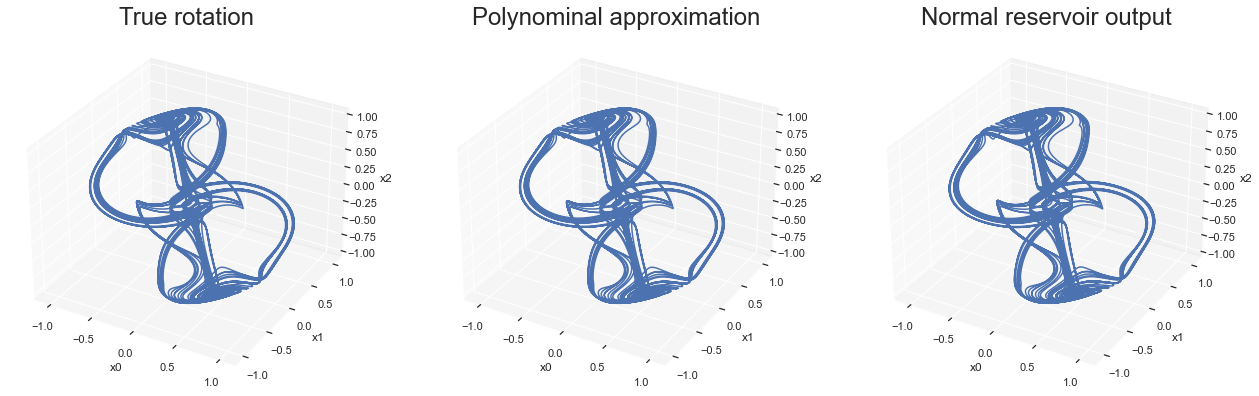

In [34]:
fig = plt.figure(figsize=(18,6))

plt.rcParams['axes.facecolor'] = 'white'

ax = fig.add_subplot(131, projection='3d')

ax.set_title('True rotation', fontsize=24)

ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.set_zlabel("x2")

# Rotate around z-axis
ax.plot(-input_xs[:,1], 
         input_xs[:,0], 
         input_xs[:,2])

ax = fig.add_subplot(132, projection='3d')

ax.set_title('Polynominal approximation', fontsize=24)

ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.set_zlabel("x2")

ax.plot(ys[:,0], 
        ys[:,1], 
        ys[:,2])

ax = fig.add_subplot(133, projection='3d')

ax.set_title('Normal reservoir output', fontsize=24)

ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.set_zlabel("x2")

ax.plot(y_recs[:,0], 
        y_recs[:,1], 
        y_recs[:,2])

fig.patch.set_facecolor('white')

plt.subplots_adjust(left=0.01, right=0.95, bottom=0, top=1)
plt.savefig('docs/thomas_rotation.png')

plt.show()

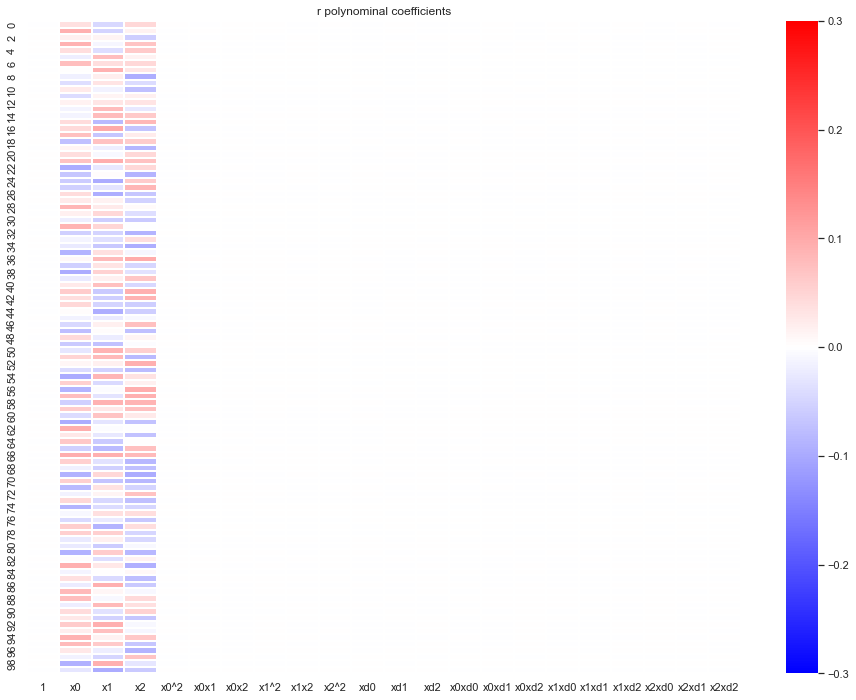

In [20]:
import seaborn as sns

xticklabels=[get_term_name(degrees) for degrees in degrees_list]
     
sns.set(rc = {'figure.figsize':(16,12)})    

plt.title('r polynominal coefficients')
sns.heatmap(all_coeffs, cmap='bwr', linewidths=0.005, vmin=-0.3, vmax=0.3,
            xticklabels=xticklabels)
plt.show()

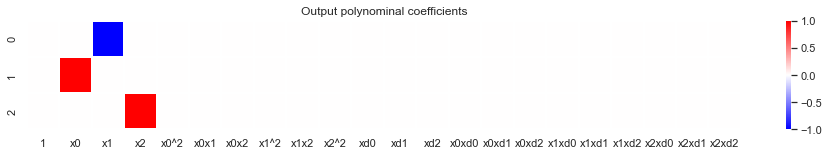

In [21]:
sns.set(rc = {'figure.figsize':(16,2)})

plt.title('Output polynominal coefficients')
sns.heatmap(target_coeffs, cmap='bwr', linewidths=0.005, vmin=-1, vmax=1,
            xticklabels=xticklabels)
plt.show()